In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [2]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [3]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [6]:
print(len(files_all))

297


In [7]:
from multiprocessing import Pool

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:03<00:00,  1.06s/it]


In [10]:
Dataset = 'Small Village Dataset'

In [11]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 60.793731689453125 [s] ... size 3251.738624 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [12]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [13]:
from timeit import default_timer as timer

In [14]:
time_all = []

In [15]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [16]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

In [ ]:
'''
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

In [ ]:
'''
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

In [ ]:
'''
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

In [ ]:
'''
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

In [ ]:
'''
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [ ]:
'''
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 50,contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000,contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [80]:

start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000,contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:00<00:00,  6.02s/it]


In [82]:

for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 350498.94it/s]


In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [17]:

print(len(left_files_path))

61


In [18]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [19]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [05:56<00:00,  5.95s/it]


In [20]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 118177.15it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create( nOctaves = 3, hessianThreshold = 20 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [08:12<00:00,  8.21s/it]


In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 183090.75it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [21]:

class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [22]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [05:55<00:00,  5.92s/it]


In [23]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 39485.09it/s]


In [ ]:
'''
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [24]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [25]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [26]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [27]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [28]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:09,  6.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 44




  7%|▋         | 4/61 [00:00<00:08,  6.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 46




 10%|▉         | 6/61 [00:00<00:08,  6.73it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 86
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 42




 13%|█▎        | 8/61 [00:01<00:08,  6.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 93



Number of matches 1001
Number of matches After Lowe's Ratio 115
Number of Robust matches 45




 16%|█▋        | 10/61 [00:01<00:07,  6.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 45




 18%|█▊        | 11/61 [00:01<00:09,  5.34it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 23


Number of matches After Lowe's Ratio New 193
Number of Robust matches New 30




 21%|██▏       | 13/61 [00:02<00:08,  5.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 19


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 27




 23%|██▎       | 14/61 [00:02<00:08,  5.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 7




 25%|██▍       | 15/61 [00:02<00:09,  4.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 12


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 12




 28%|██▊       | 17/61 [00:02<00:08,  5.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 29




 30%|██▉       | 18/61 [00:03<00:07,  5.60it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 81
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches

 31%|███       | 19/61 [00:03<00:08,  4.77it/s]

 18


Number of matches After Lowe's Ratio New 163
Number of Robust matches New 25




 34%|███▍      | 21/61 [00:03<00:07,  5.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 47




 38%|███▊      | 23/61 [00:03<00:06,  6.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 100



Number of matches 1001
Number of matches After Lowe's Ratio 116
Number of Robust matches 81




 41%|████      | 25/61 [00:04<00:05,  6.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 9


Number of matches After Lowe's Ratio New 118


 44%|████▍     | 27/61 [00:04<00:06,  4.94it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 26




 46%|████▌     | 28/61 [00:05<00:07,  4.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 12


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 13




 48%|████▊     | 29/61 [00:05<00:07,  4.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 6




 49%|████▉     | 30/61 [00:05<00:06,  4.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 9


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 12




 51%|█████     | 31/61 [00:05<00:06,  4.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 18


Number of matches After Lowe's Ratio New 130
Number of Robust matches New 22




 54%|█████▍    | 33/61 [00:06<00:05,  5.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 31




 56%|█████▌    | 34/61 [00:06<00:05,  4.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 23


Number of matches After Lowe's Ratio New 168
Number of Robust matches New 33




 59%|█████▉    | 36/61 [00:06<00:04,  5.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 35




 62%|██████▏   | 38/61 [00:06<00:03,  5.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 64




 64%|██████▍   | 39/61 [00:07<00:03,  6.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 96



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 18


Number of matches After Lowe's Ratio New 107


 66%|██████▌   | 40/61 [00:07<00:03,  5.51it/s]

Number of Robust matches New 21



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 23


Number of matches After Lowe's Ratio New 171


 67%|██████▋   | 41/61 [00:07<00:03,  5.14it/s]

Number of Robust matches New 28



Number of matches 1001
Number of matches After Lowe's Ratio 78
Number of Robust matches 20


Number of matches After Lowe's Ratio New 161


 69%|██████▉   | 42/61 [00:07<00:04,  4.71it/s]

Number of Robust matches New 21



Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 18


Number of matches After Lowe's Ratio New 110


 70%|███████   | 43/61 [00:08<00:03,  4.68it/s]

Number of Robust matches New 26



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 8


Number of matches After Lowe's Ratio New 52


 72%|███████▏  | 44/61 [00:08<00:03,  4.63it/s]

Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 54


 74%|███████▍  | 45/61 [00:08<00:03,  4.58it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 7
Number of Robust matches 5


Number of matches After Lowe's Ratio New 56


 77%|███████▋  | 47/61 [00:08<00:02,  4.72it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 12


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 21




 79%|███████▊  | 48/61 [00:09<00:02,  4.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 23


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 39



Number of matches 1000
Number of matches After Lowe's Ratio 60


 80%|████████  | 49/61 [00:09<00:02,  4.13it/s]

Number of Robust matches 12


Number of matches After Lowe's Ratio New 146
Number of Robust matches New 13




 84%|████████▎ | 51/61 [00:09<00:01,  5.15it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 73
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 39




 87%|████████▋ | 53/61 [00:10<00:01,  5.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 50




 90%|█████████ | 55/61 [00:10<00:00,  6.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 72



Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 51




 93%|█████████▎| 57/61 [00:10<00:00,  6.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 74



Number of matches 1001
Number of matches After Lowe's Ratio 61
Number of Robust matches 30




 95%|█████████▌| 58/61 [00:10<00:00,  5.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 24


Number of matches After Lowe's Ratio New 164
Number of Robust matches New 33




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 19


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 31



Number of matches 1000
Number of matches After Lowe's Ratio 14
Number of Robust matches 8


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 18




  3%|▎         | 2/60 [00:00<00:09,  6.39it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 73
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 18


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 26




  5%|▌         | 3/60 [00:00<00:09,  6.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 22


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 32



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 21


Number of matches After Lowe's Ratio New 147


  8%|▊         | 5/60 [00:00<00:09,  5.64it/s]

Number of Robust matches New 26



Number of matches 1000
Number of matches After Lowe's Ratio 145
Number of Robust matches 51




 12%|█▏        | 7/60 [00:01<00:08,  6.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 41




 15%|█▌        | 9/60 [00:01<00:07,  6.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 62




 18%|█▊        | 11/60 [00:01<00:07,  6.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 81




 22%|██▏       | 13/60 [00:02<00:07,  6.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 84




 25%|██▌       | 15/60 [00:02<00:06,  6.67it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 121
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 27




 27%|██▋       | 16/60 [00:02<00:06,  6.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 22


Number of matches After Lowe's Ratio New 130


 30%|███       | 18/60 [00:02<00:07,  5.72it/s]

Number of Robust matches New 29



Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 43




 33%|███▎      | 20/60 [00:03<00:06,  5.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 14


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 25



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 38




 37%|███▋      | 22/60 [00:03<00:05,  6.37it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 119
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 50




 40%|████      | 24/60 [00:03<00:05,  6.73it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 140
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 130
Number of Robust matches 63




 43%|████▎     | 26/60 [00:04<00:05,  6.64it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 101
Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 66




 47%|████▋     | 28/60 [00:04<00:05,  6.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 81



Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 18


Number of matches After Lowe's Ratio New 105
Number of Robust matches New 26




 50%|█████     | 30/60 [00:04<00:04,  6.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 52




 53%|█████▎    | 32/60 [00:05<00:04,  6.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 35




 57%|█████▋    | 34/60 [00:05<00:03,  6.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 26




 60%|██████    | 36/60 [00:05<00:03,  6.68it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 19


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 34




 63%|██████▎   | 38/60 [00:06<00:03,  6.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 41




 67%|██████▋   | 40/60 [00:06<00:02,  6.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 52



Number of matches 1001
Number of matches After Lowe's Ratio 127
Number of Robust matches 87




 68%|██████▊   | 41/60 [00:06<00:02,  7.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 22
Number of Robust matches 12


Number of matches After Lowe's Ratio New 80


 72%|███████▏  | 43/60 [00:06<00:02,  6.05it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 24


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 29




 75%|███████▌  | 45/60 [00:07<00:02,  5.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 28
Number of Robust matches 19


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 28



Number of matches 1001
Number of matches After Lowe's Ratio 90
Number of Robust matches 55




 78%|███████▊  | 47/60 [00:07<00:02,  6.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 44



Number of matches 1001
Number of matches After Lowe's Ratio 83
Number of Robust matches 28




 82%|████████▏ | 49/60 [00:07<00:01,  6.15it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 87
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 22


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 32




 85%|████████▌ | 51/60 [00:08<00:01,  6.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 27




 87%|████████▋ | 52/60 [00:08<00:01,  5.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 15


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 19




 88%|████████▊ | 53/60 [00:08<00:01,  4.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 21


Number of matches After Lowe's Ratio New 157
Number of Robust matches New 29




 92%|█████████▏| 55/60 [00:08<00:00,  5.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 45




 95%|█████████▌| 57/60 [00:09<00:00,  6.22it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 118
Number of Robust matches 57



Number of matches 1001
Number of matches After Lowe's Ratio 94
Number of Robust matches 56




 98%|█████████▊| 59/60 [00:09<00:00,  6.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 78



Number of matches 1000
Number of matches After Lowe's Ratio 130
Number of Robust matches 95




In [29]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009790897369384766 [s] ... size 0.006368 MB


In [30]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011440515518188477 [s] ... size 0.006296 MB


In [31]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
''''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [25]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 84857
Number of matches After Lowe's Ratio 14815


  2%|▏         | 1/61 [00:29<29:34, 29.57s/it]

Number of Robust matches 5233



Number of matches 82805
Number of matches After Lowe's Ratio 20311


  3%|▎         | 2/61 [00:51<26:57, 27.42s/it]

Number of Robust matches 6618



Number of matches 68042
Number of matches After Lowe's Ratio 12747


  5%|▍         | 3/61 [01:11<24:17, 25.13s/it]

Number of Robust matches 4688



Number of matches 74493
Number of matches After Lowe's Ratio 9955


  7%|▋         | 4/61 [01:30<22:01, 23.18s/it]

Number of Robust matches 4225




  8%|▊         | 5/61 [01:52<21:12, 22.72s/it]


Number of matches 104418
Number of matches After Lowe's Ratio 3953
Number of Robust matches 1801




 10%|▉         | 6/61 [02:23<23:08, 25.24s/it]


Number of matches 167534
Number of matches After Lowe's Ratio 690
Number of Robust matches 56



Number of matches 135317
Number of matches After Lowe's Ratio 44554


 11%|█▏        | 7/61 [03:08<28:10, 31.30s/it]

Number of Robust matches 34618




 13%|█▎        | 8/61 [03:41<28:06, 31.83s/it]


Number of matches 87115
Number of matches After Lowe's Ratio 23152
Number of Robust matches 15342




 15%|█▍        | 9/61 [04:04<25:08, 29.02s/it]


Number of matches 69241
Number of matches After Lowe's Ratio 13591
Number of Robust matches 7455



Number of matches 72181
Number of matches After Lowe's Ratio 13972


 16%|█▋        | 10/61 [04:22<21:58, 25.84s/it]

Number of Robust matches 5099



Number of matches 85113
Number of matches After Lowe's Ratio 8261


 18%|█▊        | 11/61 [04:42<20:10, 24.21s/it]

Number of Robust matches 2471




 20%|█▉        | 12/61 [05:06<19:40, 24.10s/it]


Number of matches 105845
Number of matches After Lowe's Ratio 8504
Number of Robust matches 2280




 21%|██▏       | 13/61 [05:44<22:26, 28.05s/it]


Number of matches 227178
Number of matches After Lowe's Ratio 3718
Number of Robust matches 1202



Number of matches 343673
Number of matches After Lowe's Ratio 480
Number of Robust matches 9




 23%|██▎       | 14/61 [06:57<32:42, 41.75s/it]

Number of matches After Lowe's Ratio New 480
Number of Robust matches New 8



Number of matches 203995
Number of matches After Lowe's Ratio 26190
Number of Robust matches 15165




 26%|██▌       | 16/61 [09:18<41:20, 55.12s/it]


Number of matches 143995
Number of matches After Lowe's Ratio 9588
Number of Robust matches 4308




 28%|██▊       | 17/61 [10:01<37:38, 51.32s/it]


Number of matches 94593
Number of matches After Lowe's Ratio 860
Number of Robust matches 90



Number of matches 89200
Number of matches After Lowe's Ratio 689
Number of Robust matches 24


Number of matches After Lowe's Ratio New 689


 30%|██▉       | 18/61 [10:27<31:30, 43.96s/it]

Number of Robust matches New 24




 31%|███       | 19/61 [10:51<26:31, 37.90s/it]


Number of matches 76151
Number of matches After Lowe's Ratio 765
Number of Robust matches 34



Number of matches 116324
Number of matches After Lowe's Ratio 748
Number of Robust matches 15


Number of matches After Lowe's Ratio New 748


 33%|███▎      | 20/61 [11:14<22:47, 33.34s/it]

Number of Robust matches New 14



Number of matches 168272
Number of matches After Lowe's Ratio 695
Number of Robust matches 23


Number of matches After Lowe's Ratio New 695


 34%|███▍      | 21/61 [11:51<23:05, 34.63s/it]

Number of Robust matches New 23



Number of matches 237167
Number of matches After Lowe's Ratio 803
Number of Robust matches 17


Number of matches After Lowe's Ratio New 803


 36%|███▌      | 22/61 [12:39<25:03, 38.56s/it]

Number of Robust matches New 16




 38%|███▊      | 23/61 [13:42<28:58, 45.75s/it]


Number of matches 177137
Number of matches After Lowe's Ratio 816
Number of Robust matches 275



Number of matches 108727
Number of matches After Lowe's Ratio 613
Number of Robust matches 22


Number of matches After Lowe's Ratio New 613


 39%|███▉      | 24/61 [14:26<27:59, 45.39s/it]

Number of Robust matches New 20




 41%|████      | 25/61 [14:54<24:02, 40.07s/it]


Number of matches 87870
Number of matches After Lowe's Ratio 756
Number of Robust matches 34




 43%|████▎     | 26/61 [15:16<20:16, 34.77s/it]


Number of matches 109999
Number of matches After Lowe's Ratio 887
Number of Robust matches 43




 44%|████▍     | 27/61 [15:48<19:15, 33.97s/it]


Number of matches 127853
Number of matches After Lowe's Ratio 711
Number of Robust matches 62



Number of matches 190433
Number of matches After Lowe's Ratio 574
Number of Robust matches 23




 46%|████▌     | 28/61 [16:23<18:51, 34.28s/it]

Number of matches After Lowe's Ratio New 574
Number of Robust matches New 23



Number of matches 237587
Number of matches After Lowe's Ratio 335
Number of Robust matches 11


Number of matches After Lowe's Ratio New 335


 48%|████▊     | 29/61 [17:26<22:46, 42.69s/it]

Number of Robust matches New 9




 49%|████▉     | 30/61 [18:40<26:55, 52.11s/it]


Number of matches 235139
Number of matches After Lowe's Ratio 13135
Number of Robust matches 7767




 51%|█████     | 31/61 [19:44<27:51, 55.72s/it]


Number of matches 142614
Number of matches After Lowe's Ratio 7114
Number of Robust matches 2300




 52%|█████▏    | 32/61 [20:18<23:43, 49.08s/it]


Number of matches 74989
Number of matches After Lowe's Ratio 1816
Number of Robust matches 455




 54%|█████▍    | 33/61 [20:40<19:06, 40.93s/it]


Number of matches 90642
Number of matches After Lowe's Ratio 4899
Number of Robust matches 1802




 56%|█████▌    | 34/61 [21:07<16:38, 36.99s/it]


Number of matches 125456
Number of matches After Lowe's Ratio 11467
Number of Robust matches 5347




 57%|█████▋    | 35/61 [21:41<15:39, 36.13s/it]


Number of matches 166880
Number of matches After Lowe's Ratio 19207
Number of Robust matches 10925



Number of matches 212917
Number of matches After Lowe's Ratio 29158


 59%|█████▉    | 36/61 [22:28<16:19, 39.19s/it]

Number of Robust matches 19946



Number of matches 290571
Number of matches After Lowe's Ratio 882
Number of Robust matches 23




 61%|██████    | 37/61 [23:38<19:23, 48.46s/it]

Number of matches After Lowe's Ratio New 882
Number of Robust matches New 21




 62%|██████▏   | 38/61 [24:55<21:53, 57.11s/it]


Number of matches 225076
Number of matches After Lowe's Ratio 18356
Number of Robust matches 12819




 64%|██████▍   | 39/61 [26:03<22:04, 60.23s/it]


Number of matches 178798
Number of matches After Lowe's Ratio 2078
Number of Robust matches 1374



Number of matches 107589
Number of matches After Lowe's Ratio 23394


 66%|██████▌   | 40/61 [26:46<19:20, 55.27s/it]

Number of Robust matches 16574




 67%|██████▋   | 41/61 [27:15<15:43, 47.17s/it]


Number of matches 84585
Number of matches After Lowe's Ratio 3614
Number of Robust matches 1474




 69%|██████▉   | 42/61 [27:42<13:05, 41.32s/it]


Number of matches 116428
Number of matches After Lowe's Ratio 1407
Number of Robust matches 249




 70%|███████   | 43/61 [28:16<11:42, 39.03s/it]


Number of matches 174626
Number of matches After Lowe's Ratio 9100
Number of Robust matches 2501




 72%|███████▏  | 44/61 [29:13<12:33, 44.33s/it]


Number of matches 232116
Number of matches After Lowe's Ratio 3176
Number of Robust matches 1674



Number of matches 349489
Number of matches After Lowe's Ratio 552
Number of Robust matches 12




 74%|███████▍  | 45/61 [30:33<14:43, 55.22s/it]

Number of matches After Lowe's Ratio New 552
Number of Robust matches New 10



Number of matches 272354
Number of matches After Lowe's Ratio 400
Number of Robust matches 12




 75%|███████▌  | 46/61 [32:03<16:22, 65.53s/it]

Number of matches After Lowe's Ratio New 400
Number of Robust matches New 12



Number of matches 200895
Number of matches After Lowe's Ratio 16274


 77%|███████▋  | 47/61 [33:05<15:01, 64.39s/it]

Number of Robust matches 7956



Number of matches 136719
Number of matches After Lowe's Ratio 28490


 79%|███████▊  | 48/61 [33:55<13:02, 60.23s/it]

Number of Robust matches 14975




 80%|████████  | 49/61 [34:29<10:26, 52.17s/it]


Number of matches 86766
Number of matches After Lowe's Ratio 9550
Number of Robust matches 3637



Number of matches 189558
Number of matches After Lowe's Ratio 33009


 82%|████████▏ | 50/61 [34:58<08:18, 45.28s/it]

Number of Robust matches 20250



Number of matches 210538
Number of matches After Lowe's Ratio 50334


 84%|████████▎ | 51/61 [35:51<07:57, 47.80s/it]

Number of Robust matches 35949



Number of matches 256256
Number of matches After Lowe's Ratio 58226


 85%|████████▌ | 52/61 [36:55<07:53, 52.61s/it]

Number of Robust matches 43620



Number of matches 306957
Number of matches After Lowe's Ratio 548
Number of Robust matches 13




 87%|████████▋ | 53/61 [38:13<08:01, 60.19s/it]

Number of matches After Lowe's Ratio New 548
Number of Robust matches New 12



Number of matches 320449
Number of matches After Lowe's Ratio 89732


 89%|████████▊ | 54/61 [39:31<07:39, 65.62s/it]

Number of Robust matches 69020



Number of matches 269247
Number of matches After Lowe's Ratio 17915


 90%|█████████ | 55/61 [40:55<07:06, 71.03s/it]

Number of Robust matches 13470




 92%|█████████▏| 56/61 [42:03<05:49, 70.00s/it]


Number of matches 223902
Number of matches After Lowe's Ratio 2925
Number of Robust matches 1956




 93%|█████████▎| 57/61 [42:53<04:15, 63.96s/it]


Number of matches 166224
Number of matches After Lowe's Ratio 17250
Number of Robust matches 10993




 95%|█████████▌| 58/61 [43:30<02:47, 55.97s/it]


Number of matches 115002
Number of matches After Lowe's Ratio 4747
Number of Robust matches 2776




 97%|█████████▋| 59/61 [44:19<01:47, 53.87s/it]


Number of matches 274471
Number of matches After Lowe's Ratio 9354
Number of Robust matches 4250




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 315937
Number of matches After Lowe's Ratio 7724
Number of Robust matches 4094



Number of matches 197167
Number of matches After Lowe's Ratio 31997


  2%|▏         | 1/60 [00:35<35:09, 35.75s/it]

Number of Robust matches 12920



Number of matches 258353
Number of matches After Lowe's Ratio 26462


  3%|▎         | 2/60 [01:30<39:58, 41.35s/it]

Number of Robust matches 8371



Number of matches 177757
Number of matches After Lowe's Ratio 410
Number of Robust matches 16


Number of matches After Lowe's Ratio New 410


  5%|▌         | 3/60 [02:36<46:31, 48.98s/it]

Number of Robust matches New 16




  7%|▋         | 4/60 [03:16<43:00, 46.07s/it]


Number of matches 118122
Number of matches After Lowe's Ratio 1665
Number of Robust matches 517




  8%|▊         | 5/60 [03:43<37:09, 40.54s/it]


Number of matches 80983
Number of matches After Lowe's Ratio 12833
Number of Robust matches 4559



Number of matches 78600
Number of matches After Lowe's Ratio 16980


 10%|█         | 6/60 [04:05<31:17, 34.77s/it]

Number of Robust matches 6131



Number of matches 68302
Number of matches After Lowe's Ratio 15519


 12%|█▏        | 7/60 [04:24<26:33, 30.07s/it]

Number of Robust matches 5786




 13%|█▎        | 8/60 [04:41<22:41, 26.18s/it]


Number of matches 61656
Number of matches After Lowe's Ratio 11488
Number of Robust matches 6352




 15%|█▌        | 9/60 [05:00<20:24, 24.01s/it]


Number of matches 63340
Number of matches After Lowe's Ratio 13364
Number of Robust matches 7810



Number of matches 71302
Number of matches After Lowe's Ratio 18834


 17%|█▋        | 10/60 [05:20<18:59, 22.79s/it]

Number of Robust matches 15049




 18%|█▊        | 11/60 [05:40<18:06, 22.17s/it]


Number of matches 69089
Number of matches After Lowe's Ratio 365
Number of Robust matches 15


Number of matches After Lowe's Ratio New 365
Number of Robust matches New 13




 20%|██        | 12/60 [06:02<17:35, 21.99s/it]


Number of matches 74226
Number of matches After Lowe's Ratio 12403
Number of Robust matches 8182




 22%|██▏       | 13/60 [06:21<16:33, 21.14s/it]


Number of matches 77704
Number of matches After Lowe's Ratio 16722
Number of Robust matches 8522



Number of matches 78942
Number of matches After Lowe's Ratio 19666


 23%|██▎       | 14/60 [06:41<15:59, 20.85s/it]

Number of Robust matches 8208




 25%|██▌       | 15/60 [07:02<15:31, 20.71s/it]


Number of matches 81925
Number of matches After Lowe's Ratio 14910
Number of Robust matches 6328




 27%|██▋       | 16/60 [07:24<15:35, 21.27s/it]


Number of matches 106277
Number of matches After Lowe's Ratio 16320
Number of Robust matches 8178



Number of matches 178507
Number of matches After Lowe's Ratio 27831


 28%|██▊       | 17/60 [07:55<17:14, 24.07s/it]

Number of Robust matches 14690



Number of matches 196503
Number of matches After Lowe's Ratio 35624


 30%|███       | 18/60 [08:46<22:33, 32.23s/it]

Number of Robust matches 14952




 32%|███▏      | 19/60 [09:38<26:04, 38.15s/it]


Number of matches 184077
Number of matches After Lowe's Ratio 552
Number of Robust matches 82




 33%|███▎      | 20/60 [10:16<25:21, 38.04s/it]


Number of matches 101834
Number of matches After Lowe's Ratio 2136
Number of Robust matches 906




 35%|███▌      | 21/60 [10:41<22:16, 34.28s/it]


Number of matches 100681
Number of matches After Lowe's Ratio 15985
Number of Robust matches 6389




 37%|███▋      | 22/60 [11:05<19:36, 30.96s/it]


Number of matches 80995
Number of matches After Lowe's Ratio 13683
Number of Robust matches 5626




 38%|███▊      | 23/60 [11:24<16:59, 27.56s/it]


Number of matches 70753
Number of matches After Lowe's Ratio 16557
Number of Robust matches 6210




 40%|████      | 24/60 [11:45<15:21, 25.59s/it]


Number of matches 68700
Number of matches After Lowe's Ratio 20035
Number of Robust matches 11635




 42%|████▏     | 25/60 [12:04<13:44, 23.54s/it]


Number of matches 54700
Number of matches After Lowe's Ratio 20351
Number of Robust matches 14279




 43%|████▎     | 26/60 [12:17<11:37, 20.50s/it]


Number of matches 32030
Number of matches After Lowe's Ratio 10335
Number of Robust matches 8299



Number of matches 37212
Number of matches After Lowe's Ratio 374
Number of Robust matches 13


Number of matches After Lowe's Ratio New 374
Number of Robust matches New

 45%|████▌     | 27/60 [12:26<09:22, 17.03s/it]

 12




 47%|████▋     | 28/60 [12:41<08:42, 16.33s/it]


Number of matches 87049
Number of matches After Lowe's Ratio 17234
Number of Robust matches 11276




 48%|████▊     | 29/60 [13:06<09:48, 18.99s/it]


Number of matches 105444
Number of matches After Lowe's Ratio 26047
Number of Robust matches 13541



Number of matches 102446
Number of matches After Lowe's Ratio 25251


 50%|█████     | 30/60 [13:34<10:46, 21.56s/it]

Number of Robust matches 9942




 52%|█████▏    | 31/60 [13:59<10:54, 22.58s/it]


Number of matches 107602
Number of matches After Lowe's Ratio 20985
Number of Robust matches 8184



Number of matches 130388
Number of matches After Lowe's Ratio 16530


 53%|█████▎    | 32/60 [14:29<11:32, 24.75s/it]

Number of Robust matches 9997



Number of matches 162117
Number of matches After Lowe's Ratio 22670


 55%|█████▌    | 33/60 [15:08<13:03, 29.01s/it]

Number of Robust matches 15401



Number of matches 271554
Number of matches After Lowe's Ratio 43143


 57%|█████▋    | 34/60 [16:04<16:05, 37.14s/it]

Number of Robust matches 28638



Number of matches 206437
Number of matches After Lowe's Ratio 372
Number of Robust matches 14


Number of matches After Lowe's Ratio New 372


 58%|█████▊    | 35/60 [17:17<20:02, 48.10s/it]

Number of Robust matches New 14




 60%|██████    | 36/60 [18:07<19:28, 48.69s/it]


Number of matches 150075
Number of matches After Lowe's Ratio 832
Number of Robust matches 223



Number of matches 113380
Number of matches After Lowe's Ratio 16851


 62%|██████▏   | 37/60 [18:47<17:37, 45.99s/it]

Number of Robust matches 10225




 63%|██████▎   | 38/60 [19:18<15:08, 41.31s/it]


Number of matches 105952
Number of matches After Lowe's Ratio 20319
Number of Robust matches 7427




 65%|██████▌   | 39/60 [19:43<12:49, 36.65s/it]


Number of matches 86727
Number of matches After Lowe's Ratio 24186
Number of Robust matches 9835



Number of matches 87373
Number of matches After Lowe's Ratio 29391


 67%|██████▋   | 40/60 [20:05<10:46, 32.32s/it]

Number of Robust matches 18323




 68%|██████▊   | 41/60 [20:24<08:58, 28.32s/it]


Number of matches 61128
Number of matches After Lowe's Ratio 18900
Number of Robust matches 16031




 70%|███████   | 42/60 [20:34<06:46, 22.56s/it]


Number of matches 1260
Number of matches After Lowe's Ratio 434
Number of Robust matches 268




 72%|███████▏  | 43/60 [20:37<04:43, 16.67s/it]


Number of matches 52855
Number of matches After Lowe's Ratio 531
Number of Robust matches 23


Number of matches After Lowe's Ratio New 531
Number of Robust matches New 23




 73%|███████▎  | 44/60 [20:52<04:20, 16.31s/it]


Number of matches 82008
Number of matches After Lowe's Ratio 18047
Number of Robust matches 14951



Number of matches 109195
Number of matches After Lowe's Ratio 24807


 75%|███████▌  | 45/60 [21:16<04:38, 18.57s/it]

Number of Robust matches 14207




 77%|███████▋  | 46/60 [21:44<04:58, 21.34s/it]


Number of matches 95312
Number of matches After Lowe's Ratio 15539
Number of Robust matches 7516




 78%|███████▊  | 47/60 [22:14<05:11, 23.95s/it]


Number of matches 115231
Number of matches After Lowe's Ratio 13330
Number of Robust matches 5254



Number of matches 177649
Number of matches After Lowe's Ratio 22472


 80%|████████  | 48/60 [22:50<05:32, 27.73s/it]

Number of Robust matches 14099




 82%|████████▏ | 49/60 [23:32<05:50, 31.83s/it]


Number of matches 144782
Number of matches After Lowe's Ratio 23027
Number of Robust matches 14597



Number of matches 224270
Number of matches After Lowe's Ratio 47135


 83%|████████▎ | 50/60 [24:12<05:44, 34.43s/it]

Number of Robust matches 31011




 85%|████████▌ | 51/60 [25:05<05:58, 39.84s/it]


Number of matches 150305
Number of matches After Lowe's Ratio 830
Number of Robust matches 300



Number of matches 187224
Number of matches After Lowe's Ratio 19352


 87%|████████▋ | 52/60 [25:50<05:31, 41.48s/it]

Number of Robust matches 10012




 88%|████████▊ | 53/60 [26:36<05:00, 42.87s/it]


Number of matches 129611
Number of matches After Lowe's Ratio 17454
Number of Robust matches 8528




 90%|█████████ | 54/60 [27:08<03:57, 39.63s/it]


Number of matches 100649
Number of matches After Lowe's Ratio 14784
Number of Robust matches 5276




 92%|█████████▏| 55/60 [27:31<02:52, 34.55s/it]


Number of matches 88759
Number of matches After Lowe's Ratio 13327
Number of Robust matches 6667



Number of matches 75721
Number of matches After Lowe's Ratio 22433


 93%|█████████▎| 56/60 [27:52<02:01, 30.47s/it]

Number of Robust matches 15620




 95%|█████████▌| 57/60 [28:09<01:19, 26.38s/it]


Number of matches 55071
Number of matches After Lowe's Ratio 22171
Number of Robust matches 20226




 97%|█████████▋| 58/60 [28:19<00:43, 21.71s/it]


Number of matches 25212
Number of matches After Lowe's Ratio 13331
Number of Robust matches 12259



Number of matches 51841
Number of matches After Lowe's Ratio 373
Number of Robust matches 12


Number of matches After Lowe's Ratio New 373


 98%|█████████▊| 59/60 [28:27<00:17, 17.46s/it]

Number of Robust matches New 11




In [26]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.16475343704223633 [s] ... size 0.006368 MB


In [27]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.06866621971130371 [s] ... size 0.006296 MB


In [28]:

del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [84]:

H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.9,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.9,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:23,  2.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 378
Number of Robust matches 88




  3%|▎         | 2/61 [00:00<00:22,  2.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 415
Number of Robust matches 109




  5%|▍         | 3/61 [00:01<00:22,  2.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 419
Number of Robust matches 80




  7%|▋         | 4/61 [00:01<00:21,  2.63it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 446
Number of Robust matches 151




  8%|▊         | 5/61 [00:01<00:21,  2.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 323
Number of Robust matches 82




 10%|▉         | 6/61 [00:02<00:21,  2.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 179
Number of Robust matches 25




 11%|█▏        | 7/61 [00:02<00:20,  2.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 411
Number of Robust matches 140




 13%|█▎        | 8/61 [00:03<00:19,  2.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 399
Number of Robust matches 146




 15%|█▍        | 9/61 [00:03<00:19,  2.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 465
Number of Robust matches 159




 16%|█▋        | 10/61 [00:03<00:18,  2.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 452
Number of Robust matches 136




 18%|█▊        | 11/61 [00:04<00:19,  2.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 429
Number of Robust matches 79




 20%|█▉        | 12/61 [00:04<00:18,  2.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 105




 21%|██▏       | 13/61 [00:04<00:19,  2.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 182
Number of Robust matches 29




 23%|██▎       | 14/61 [00:05<00:18,  2.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 121
Number of Robust matches 13


Number of matches After Lowe's Ratio New 32
Number of Robust matches New 8




 25%|██▍       | 15/61 [00:05<00:18,  2.49it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 163
Number of Robust matches 28




 26%|██▌       | 16/61 [00:06<00:17,  2.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 272
Number of Robust matches 51




 28%|██▊       | 17/61 [00:06<00:17,  2.47it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 294
Number of Robust matches 54




 30%|██▉       | 18/61 [00:07<00:18,  2.35it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 246
Number of Robust matches 15


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 12




 31%|███       | 19/61 [00:07<00:18,  2.29it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 227
Number of Robust matches 14


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 12




 33%|███▎      | 20/61 [00:08<00:18,  2.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 263
Number of Robust matches 14


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 10




 34%|███▍      | 21/61 [00:08<00:17,  2.28it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 202
Number of Robust matches 27




 36%|███▌      | 22/61 [00:08<00:17,  2.26it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 214
Number of Robust matches 17


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 16




 38%|███▊      | 23/61 [00:09<00:15,  2.42it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 283
Number of Robust matches 92




 39%|███▉      | 24/61 [00:09<00:16,  2.30it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 293
Number of Robust matches 21


Number of matches After Lowe's Ratio New 145
Number of Robust matches New 13




 41%|████      | 25/61 [00:10<00:15,  2.34it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 259
Number of Robust matches 29




 43%|████▎     | 26/61 [00:10<00:15,  2.26it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 221
Number of Robust matches 13


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 10




 44%|████▍     | 27/61 [00:11<00:14,  2.31it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 258
Number of Robust matches 29




 46%|████▌     | 28/61 [00:11<00:14,  2.35it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 200
Number of Robust matches 25




 48%|████▊     | 29/61 [00:11<00:13,  2.29it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 173
Number of Robust matches 13


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 9




 49%|████▉     | 30/61 [00:12<00:14,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 175
Number of Robust matches 12


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 10




 51%|█████     | 31/61 [00:12<00:13,  2.28it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 239
Number of Robust matches 29




 52%|█████▏    | 32/61 [00:13<00:12,  2.33it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 365
Number of Robust matches 52




 54%|█████▍    | 33/61 [00:13<00:11,  2.36it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 386
Number of Robust matches 67




 56%|█████▌    | 34/61 [00:14<00:12,  2.16it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 426
Number of Robust matches 106




 57%|█████▋    | 35/61 [00:14<00:11,  2.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 379
Number of Robust matches 108




 59%|█████▉    | 36/61 [00:14<00:10,  2.37it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 369
Number of Robust matches 96




 61%|██████    | 37/61 [00:15<00:10,  2.27it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 186
Number of Robust matches 14


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 8




 62%|██████▏   | 38/61 [00:15<00:09,  2.42it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 344
Number of Robust matches 116




 64%|██████▍   | 39/61 [00:16<00:08,  2.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 303
Number of Robust matches 89




 66%|██████▌   | 40/61 [00:16<00:08,  2.49it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 301
Number of Robust matches 54




 67%|██████▋   | 41/61 [00:16<00:08,  2.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 282
Number of Robust matches 51




 69%|██████▉   | 42/61 [00:17<00:07,  2.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 311
Number of Robust matches 62




 70%|███████   | 43/61 [00:17<00:07,  2.47it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 288
Number of Robust matches 43




 72%|███████▏  | 44/61 [00:18<00:07,  2.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 141
Number of Robust matches 20


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 13




 74%|███████▍  | 45/61 [00:18<00:06,  2.32it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 134
Number of Robust matches 14


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 9




 75%|███████▌  | 46/61 [00:19<00:06,  2.31it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 142
Number of Robust matches 13


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 10




 77%|███████▋  | 47/61 [00:19<00:05,  2.34it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 141
Number of Robust matches 27




 79%|███████▊  | 48/61 [00:19<00:05,  2.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 278
Number of Robust matches 55




 80%|████████  | 49/61 [00:20<00:05,  2.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 338
Number of Robust matches 47




 82%|████████▏ | 50/61 [00:20<00:04,  2.41it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 333
Number of Robust matches 42




 84%|████████▎ | 51/61 [00:21<00:03,  2.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 266
Number of Robust matches 90




 85%|████████▌ | 52/61 [00:21<00:03,  2.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 297
Number of Robust matches 83




 87%|████████▋ | 53/61 [00:21<00:03,  2.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 136
Number of Robust matches 13


Number of matches After Lowe's Ratio New 33
Number of Robust matches New 9




 89%|████████▊ | 54/61 [00:22<00:02,  2.64it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 295
Number of Robust matches 118




 90%|█████████ | 55/61 [00:22<00:02,  2.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 212
Number of Robust matches 100




 92%|█████████▏| 56/61 [00:22<00:01,  2.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 207
Number of Robust matches 84




 93%|█████████▎| 57/61 [00:23<00:01,  2.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 299
Number of Robust matches 28




 95%|█████████▌| 58/61 [00:23<00:01,  2.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 269
Number of Robust matches 60




 97%|█████████▋| 59/61 [00:24<00:00,  2.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 195
Number of Robust matches 43




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 155
Number of Robust matches 26




  2%|▏         | 1/60 [00:00<00:25,  2.34it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 293
Number of Robust matches 56




  3%|▎         | 2/60 [00:00<00:24,  2.41it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 305
Number of Robust matches 71




  5%|▌         | 3/60 [00:01<00:24,  2.33it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 187
Number of Robust matches 18


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 13




  7%|▋         | 4/60 [00:01<00:23,  2.37it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 261
Number of Robust matches 37




  8%|▊         | 5/60 [00:02<00:22,  2.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 440
Number of Robust matches 125




 10%|█         | 6/60 [00:02<00:22,  2.42it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 503
Number of Robust matches 87




 12%|█▏        | 7/60 [00:02<00:21,  2.46it/s]


Number of matches 2004
Number of matches After Lowe's Ratio 437
Number of Robust matches 122




 13%|█▎        | 8/60 [00:03<00:20,  2.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 506
Number of Robust matches 157




 15%|█▌        | 9/60 [00:03<00:19,  2.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 468
Number of Robust matches 181




 17%|█▋        | 10/60 [00:03<00:18,  2.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 464
Number of Robust matches 168




 18%|█▊        | 11/60 [00:04<00:20,  2.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 209
Number of Robust matches 13


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 11




 20%|██        | 12/60 [00:04<00:19,  2.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 306
Number of Robust matches 95




 22%|██▏       | 13/60 [00:05<00:18,  2.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 478
Number of Robust matches 172




 23%|██▎       | 14/60 [00:05<00:18,  2.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 455
Number of Robust matches 118




 25%|██▌       | 15/60 [00:05<00:17,  2.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 415
Number of Robust matches 95




 27%|██▋       | 16/60 [00:06<00:17,  2.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 403
Number of Robust matches 86




 28%|██▊       | 17/60 [00:06<00:17,  2.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 289
Number of Robust matches 44




 30%|███       | 18/60 [00:07<00:16,  2.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 238
Number of Robust matches 63




 32%|███▏      | 19/60 [00:07<00:17,  2.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 14


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 10




 33%|███▎      | 20/60 [00:08<00:16,  2.44it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 307
Number of Robust matches 57




 35%|███▌      | 21/60 [00:08<00:15,  2.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 410
Number of Robust matches 117




 37%|███▋      | 22/60 [00:08<00:14,  2.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 383
Number of Robust matches 115




 38%|███▊      | 23/60 [00:09<00:14,  2.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 495
Number of Robust matches 141




 40%|████      | 24/60 [00:09<00:13,  2.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 470
Number of Robust matches 156




 42%|████▏     | 25/60 [00:09<00:13,  2.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 523
Number of Robust matches 171




 43%|████▎     | 26/60 [00:10<00:12,  2.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 372
Number of Robust matches 128




 45%|████▌     | 27/60 [00:10<00:13,  2.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 214
Number of Robust matches 14


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 14




 47%|████▋     | 28/60 [00:11<00:12,  2.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 245
Number of Robust matches 69




 48%|████▊     | 29/60 [00:11<00:11,  2.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 499
Number of Robust matches 154




 50%|█████     | 30/60 [00:11<00:11,  2.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 554
Number of Robust matches 161




 52%|█████▏    | 31/60 [00:12<00:10,  2.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 402
Number of Robust matches 109




 53%|█████▎    | 32/60 [00:12<00:10,  2.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 415
Number of Robust matches 112




 55%|█████▌    | 33/60 [00:12<00:10,  2.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 473
Number of Robust matches 158




 57%|█████▋    | 34/60 [00:13<00:10,  2.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 327
Number of Robust matches 75




 58%|█████▊    | 35/60 [00:14<00:11,  2.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 18


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 14




 60%|██████    | 36/60 [00:14<00:11,  2.02it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 334
Number of Robust matches 57




 62%|██████▏   | 37/60 [00:15<00:11,  2.01it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 407
Number of Robust matches 115




 63%|██████▎   | 38/60 [00:15<00:11,  1.98it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 435
Number of Robust matches 111




 65%|██████▌   | 39/60 [00:16<00:10,  2.00it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 508
Number of Robust matches 151




 67%|██████▋   | 40/60 [00:16<00:09,  2.06it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 585
Number of Robust matches 274




 68%|██████▊   | 41/60 [00:17<00:09,  2.09it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 250
Number of Robust matches 70




 70%|███████   | 42/60 [00:17<00:08,  2.02it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 140
Number of Robust matches 25




 72%|███████▏  | 43/60 [00:17<00:07,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 58
Number of Robust matches 31




 73%|███████▎  | 44/60 [00:18<00:07,  2.04it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 215
Number of Robust matches 39




 75%|███████▌  | 45/60 [00:18<00:07,  2.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 366
Number of Robust matches 147




 77%|███████▋  | 46/60 [00:19<00:06,  2.11it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 477
Number of Robust matches 133




 78%|███████▊  | 47/60 [00:19<00:06,  2.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 417
Number of Robust matches 93




 80%|████████  | 48/60 [00:20<00:06,  2.00it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 395
Number of Robust matches 84




 82%|████████▏ | 49/60 [00:21<00:05,  1.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 223
Number of Robust matches 11


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 11




 83%|████████▎ | 50/60 [00:21<00:05,  1.87it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 175
Number of Robust matches 30




 85%|████████▌ | 51/60 [00:22<00:05,  1.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 179
Number of Robust matches 11


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 11




 87%|████████▋ | 52/60 [00:22<00:04,  1.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 306
Number of Robust matches 35




 88%|████████▊ | 53/60 [00:23<00:03,  1.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 369
Number of Robust matches 52




 90%|█████████ | 54/60 [00:23<00:03,  1.97it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 484
Number of Robust matches 151




 92%|█████████▏| 55/60 [00:24<00:02,  2.00it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 509
Number of Robust matches 161




 93%|█████████▎| 56/60 [00:24<00:01,  2.03it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 506
Number of Robust matches 210




 95%|█████████▌| 57/60 [00:25<00:01,  2.09it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 366
Number of Robust matches 166




 97%|█████████▋| 58/60 [00:25<00:00,  2.12it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 268
Number of Robust matches 89




 98%|█████████▊| 59/60 [00:26<00:00,  1.95it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 177
Number of Robust matches 17


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 13




In [85]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009500980377197266 [s] ... size 0.006368 MB


In [86]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0050928592681884766 [s] ... size 0.006296 MB


In [87]:

del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [ ]:
'''
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [52]:

H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:10,  5.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 294


  5%|▍         | 3/61 [00:00<00:10,  5.75it/s]

Number of Robust matches 48



Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 39




  7%|▋         | 4/61 [00:00<00:09,  5.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 325
Number of Robust matches 80



Number of matches 1001
Number of matches After Lowe's Ratio 275


 10%|▉         | 6/61 [00:01<00:08,  6.17it/s]

Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 249
Number of Robust matches 64




 13%|█▎        | 8/61 [00:01<00:08,  6.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 118



Number of matches 1001
Number of matches After Lowe's Ratio 257
Number of Robust matches 65




 15%|█▍        | 9/61 [00:01<00:07,  6.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 97



Number of matches 1000
Number of matches After Lowe's Ratio 297


 18%|█▊        | 11/61 [00:01<00:08,  6.00it/s]

Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 34




 20%|█▉        | 12/61 [00:01<00:08,  5.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 167


 21%|██▏       | 13/61 [00:02<00:08,  5.83it/s]

Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 7


Number of matches After Lowe's Ratio New 37


 23%|██▎       | 14/61 [00:02<00:09,  5.00it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 11


Number of matches After Lowe's Ratio New 39


 26%|██▌       | 16/61 [00:02<00:08,  5.39it/s]

Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 280
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 274


 30%|██▉       | 18/61 [00:03<00:07,  5.46it/s]

Number of Robust matches 53



Number of matches 1001
Number of matches After Lowe's Ratio 251
Number of Robust matches 30




 31%|███       | 19/61 [00:03<00:08,  4.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 23


Number of matches After Lowe's Ratio New 155
Number of Robust matches New 27




 33%|███▎      | 20/61 [00:03<00:08,  4.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 253
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 242


 36%|███▌      | 22/61 [00:03<00:06,  6.01it/s]

Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 275
Number of Robust matches 120




 39%|███▉      | 24/61 [00:04<00:05,  6.25it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 255
Number of Robust matches 108



Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 36




 41%|████      | 25/61 [00:04<00:05,  6.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 255
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 205


 43%|████▎     | 26/61 [00:04<00:06,  5.29it/s]

Number of Robust matches 13


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 281


 44%|████▍     | 27/61 [00:04<00:06,  5.39it/s]

Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 176
Number of Robust matches 14


Number of matches After Lowe's Ratio New 85


 46%|████▌     | 28/61 [00:04<00:06,  4.98it/s]

Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 6


Number of matches After Lowe's Ratio New 59


 48%|████▊     | 29/61 [00:05<00:06,  4.74it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 8


Number of matches After Lowe's Ratio New 60


 49%|████▉     | 30/61 [00:05<00:06,  4.47it/s]

Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 211
Number of Robust matches 22


Number of matches After Lowe's Ratio New 96


 52%|█████▏    | 32/61 [00:05<00:06,  4.80it/s]

Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 41




 54%|█████▍    | 33/61 [00:06<00:05,  5.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 274
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 267


 57%|█████▋    | 35/61 [00:06<00:04,  5.37it/s]

Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 46




 61%|██████    | 37/61 [00:06<00:04,  5.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 260
Number of Robust matches 72




 64%|██████▍   | 39/61 [00:06<00:03,  7.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 281
Number of Robust matches 87



Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 120




 66%|██████▌   | 40/61 [00:07<00:03,  6.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 24


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 25




 67%|██████▋   | 41/61 [00:07<00:03,  5.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 35



Number of matches 1001
Number of matches After Lowe's Ratio 252


 70%|███████   | 43/61 [00:07<00:03,  5.86it/s]

Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 191
Number of Robust matches 35




 72%|███████▏  | 44/61 [00:07<00:03,  5.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 120
Number of Robust matches 12


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 12




 74%|███████▍  | 45/61 [00:08<00:03,  4.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 8


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 6




 75%|███████▌  | 46/61 [00:08<00:03,  4.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 15


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 13




 79%|███████▊  | 48/61 [00:08<00:02,  5.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 135
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 68




 80%|████████  | 49/61 [00:08<00:02,  5.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 211
Number of Robust matches 16


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 15




 84%|████████▎ | 51/61 [00:09<00:01,  5.93it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 235
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 204
Number of Robust matches 85




 87%|████████▋ | 53/61 [00:09<00:01,  6.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 198
Number of Robust matches 61



Number of matches 1000
Number of matches After Lowe's Ratio 202
Number of Robust matches 66




 90%|█████████ | 55/61 [00:09<00:00,  7.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 223
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 187
Number of Robust matches 89




 93%|█████████▎| 57/61 [00:09<00:00,  7.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 200
Number of Robust matches 118



Number of matches 1001
Number of matches After Lowe's Ratio 214
Number of Robust matches 58




 95%|█████████▌| 58/61 [00:10<00:00,  6.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 173


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 44



Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 19


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 17




  2%|▏         | 1/60 [00:00<00:10,  5.88it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 242
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 181


  5%|▌         | 3/60 [00:00<00:09,  5.76it/s]

Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 30




  7%|▋         | 4/60 [00:00<00:09,  5.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 329


 10%|█         | 6/60 [00:01<00:09,  5.66it/s]

Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 53




 12%|█▏        | 7/60 [00:01<00:09,  5.65it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 319


 15%|█▌        | 9/60 [00:01<00:07,  6.51it/s]

Number of Robust matches 80



Number of matches 1000
Number of matches After Lowe's Ratio 315
Number of Robust matches 93




 18%|█▊        | 11/60 [00:01<00:06,  7.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 83



Number of matches 1000
Number of matches After Lowe's Ratio 286
Number of Robust matches 93




 22%|██▏       | 13/60 [00:02<00:06,  7.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 245
Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 104




 23%|██▎       | 14/60 [00:02<00:06,  6.66it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 334
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 263


 27%|██▋       | 16/60 [00:02<00:07,  6.20it/s]

Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 43




 30%|███       | 18/60 [00:02<00:06,  6.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 62




 32%|███▏      | 19/60 [00:03<00:06,  5.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 222


 35%|███▌      | 21/60 [00:03<00:06,  5.84it/s]

Number of Robust matches 46



Number of matches 1001
Number of matches After Lowe's Ratio 309
Number of Robust matches 56




 38%|███▊      | 23/60 [00:03<00:05,  6.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 277
Number of Robust matches 64



Number of matches 1001
Number of matches After Lowe's Ratio 340
Number of Robust matches 77




 42%|████▏     | 25/60 [00:03<00:04,  7.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 332
Number of Robust matches 95



Number of matches 1001
Number of matches After Lowe's Ratio 279
Number of Robust matches 94




 45%|████▌     | 27/60 [00:04<00:04,  7.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 253
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 109




 47%|████▋     | 28/60 [00:04<00:04,  7.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 186
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 312


 50%|█████     | 30/60 [00:04<00:04,  6.62it/s]

Number of Robust matches 81



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 66




 52%|█████▏    | 31/60 [00:04<00:04,  6.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 305


 55%|█████▌    | 33/60 [00:05<00:04,  6.45it/s]

Number of Robust matches 55



Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 76




 57%|█████▋    | 34/60 [00:05<00:04,  6.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 167


 60%|██████    | 36/60 [00:05<00:03,  6.00it/s]

Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 261
Number of Robust matches 56




 62%|██████▏   | 37/60 [00:05<00:03,  6.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 61



Number of matches 1000
Number of matches After Lowe's Ratio 280


 65%|██████▌   | 39/60 [00:06<00:03,  6.08it/s]

Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 320
Number of Robust matches 73




 68%|██████▊   | 41/60 [00:06<00:03,  6.24it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 292
Number of Robust matches 97



Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 41




 70%|███████   | 42/60 [00:06<00:03,  5.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 7


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 13




 72%|███████▏  | 43/60 [00:06<00:03,  5.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 34



Number of matches 1000
Number of matches After Lowe's Ratio 154


 75%|███████▌  | 45/60 [00:07<00:02,  5.98it/s]

Number of Robust matches 28



Number of matches 1001
Number of matches After Lowe's Ratio 259
Number of Robust matches 82




 77%|███████▋  | 46/60 [00:07<00:02,  6.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 281
Number of Robust matches 64



Number of matches 1001
Number of matches After Lowe's Ratio 257


 80%|████████  | 48/60 [00:07<00:02,  5.98it/s]

Number of Robust matches 34



Number of matches 1001
Number of matches After Lowe's Ratio 254
Number of Robust matches 52




 82%|████████▏ | 49/60 [00:07<00:01,  5.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 203


 85%|████████▌ | 51/60 [00:08<00:01,  5.69it/s]

Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 209
Number of Robust matches 37




 87%|████████▋ | 52/60 [00:08<00:01,  5.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 22


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 20




 88%|████████▊ | 53/60 [00:08<00:01,  5.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 247
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 306


 92%|█████████▏| 55/60 [00:09<00:00,  5.54it/s]

Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 300
Number of Robust matches 59




 95%|█████████▌| 57/60 [00:09<00:00,  6.48it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 288
Number of Robust matches 85



Number of matches 1001
Number of matches After Lowe's Ratio 265
Number of Robust matches 88




 98%|█████████▊| 59/60 [00:09<00:00,  7.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 218
Number of Robust matches 88



Number of matches 1000
Number of matches After Lowe's Ratio 265
Number of Robust matches 115




In [53]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008107662200927734 [s] ... size 0.006368 MB


In [54]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010056495666503906 [s] ... size 0.006296 MB


In [55]:

del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [88]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 3

In [89]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_sift + num_kps_rootsift + num_kps_daisy, 'Detector/Descriptor': ['SIFT']*len_files + ['ROOTSIFT']*len_files + ['DAISY+SIFT']*len_files  }
df_numkey_3 = pd.DataFrame(data=d)
df_numkey_3['Number of Keypoints'] = df_numkey_3['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

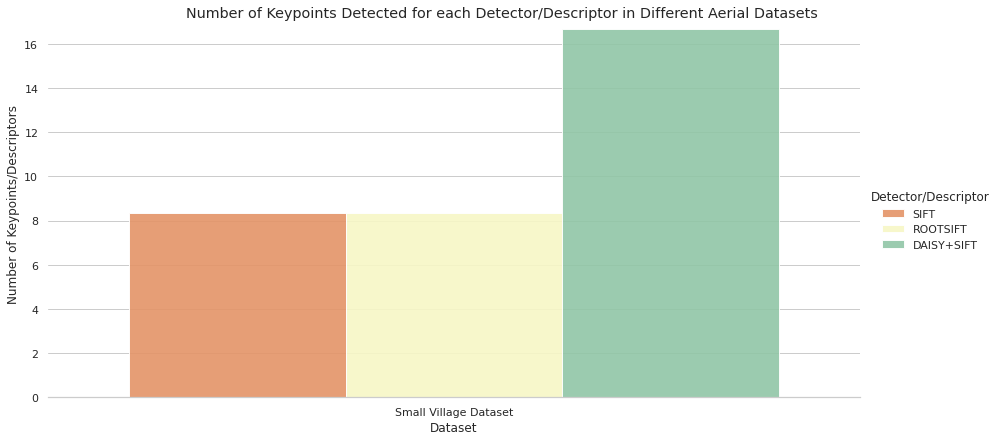

In [90]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_3, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_1_{Dataset}.png')

In [91]:
df_numkey_3.to_csv(f'drive/MyDrive/Num_Kypoints_3_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [92]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_rootsift + num_matches_sift + num_matches_daisy , 'Detector/Descriptor': ['ROOTSIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) }
df_match_3 = pd.DataFrame(data=d)
df_match_3['Number of Total Matches'] = df_match_3['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

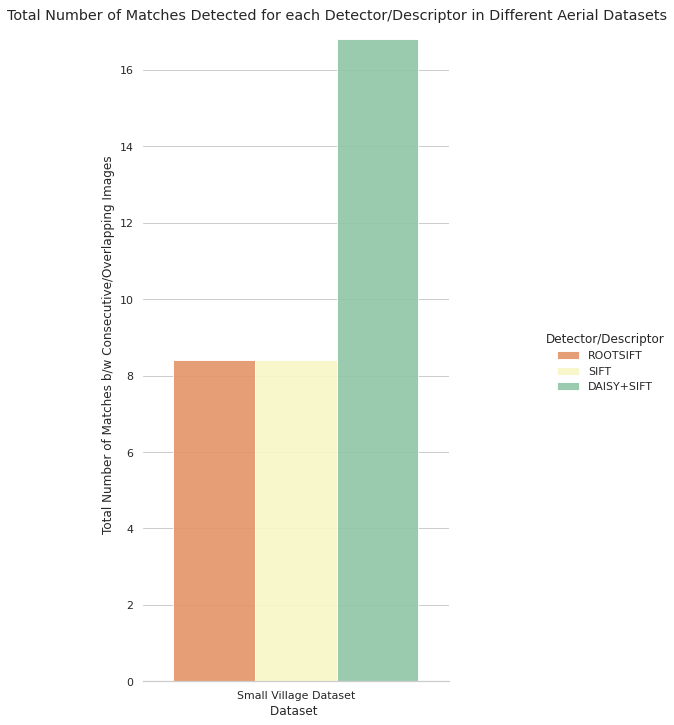

In [93]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_1_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [94]:
df_match_3['Number of Good Matches'] = num_good_matches_sift + num_good_matches_rootsift + num_good_matches_daisy
df_match_3['Number of Good Matches'] = df_match_3['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

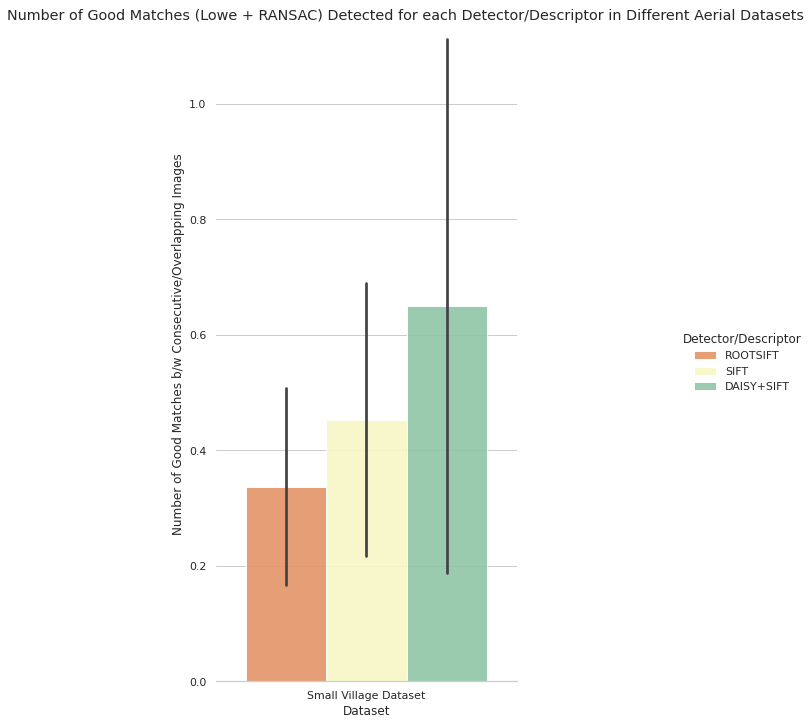

In [95]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_1.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [96]:
df_match_3['Recall Rate of Matches'] = df_match_3['Number of Good Matches']/df_match_3['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

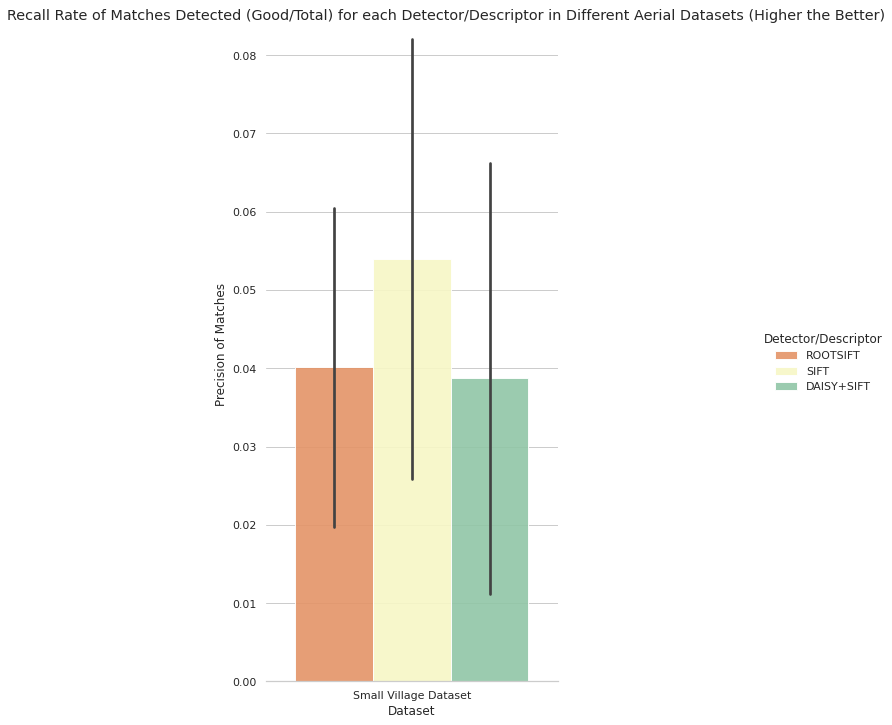

In [97]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_1.png')

1-Precision Rate for each Detector+Descriptor

In [98]:
df_match_3['1 - Precision Rate of Matches'] = (df_match_3['Number of Total Matches'] - df_match_3['Number of Good Matches'])/df_match_3['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

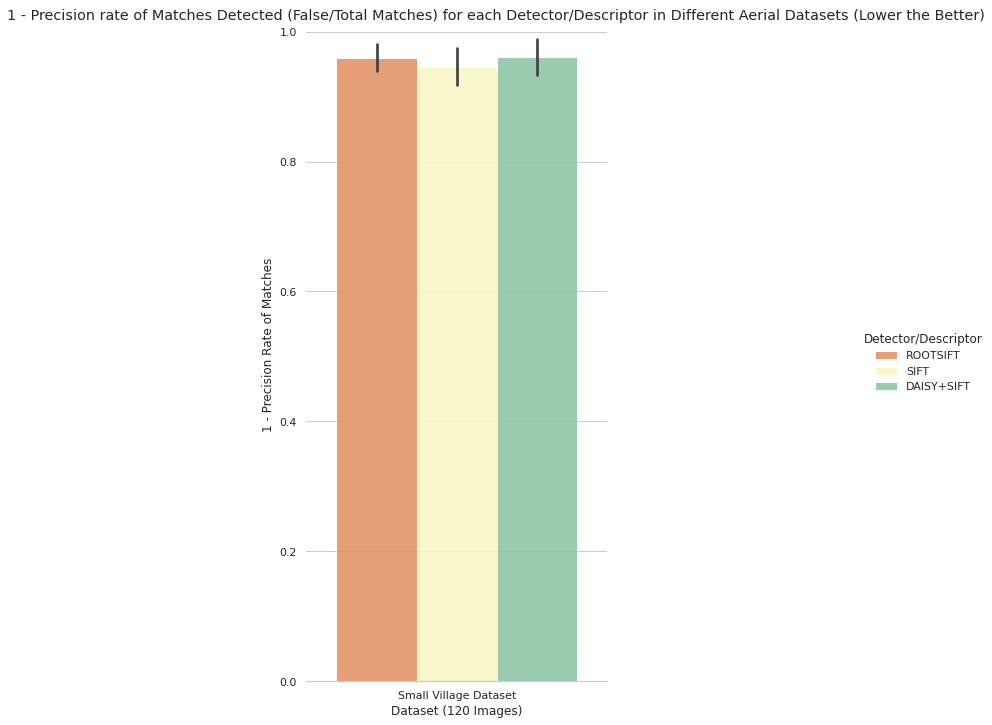

In [99]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_1.png')

F-Score for each Detector+Descriptor

In [100]:
df_match_3['F-Score'] = (2* (1 - df_match_3['1 - Precision Rate of Matches']) * df_match_3['Recall Rate of Matches'])/((1 - df_match_3['1 - Precision Rate of Matches']) + df_match_3['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

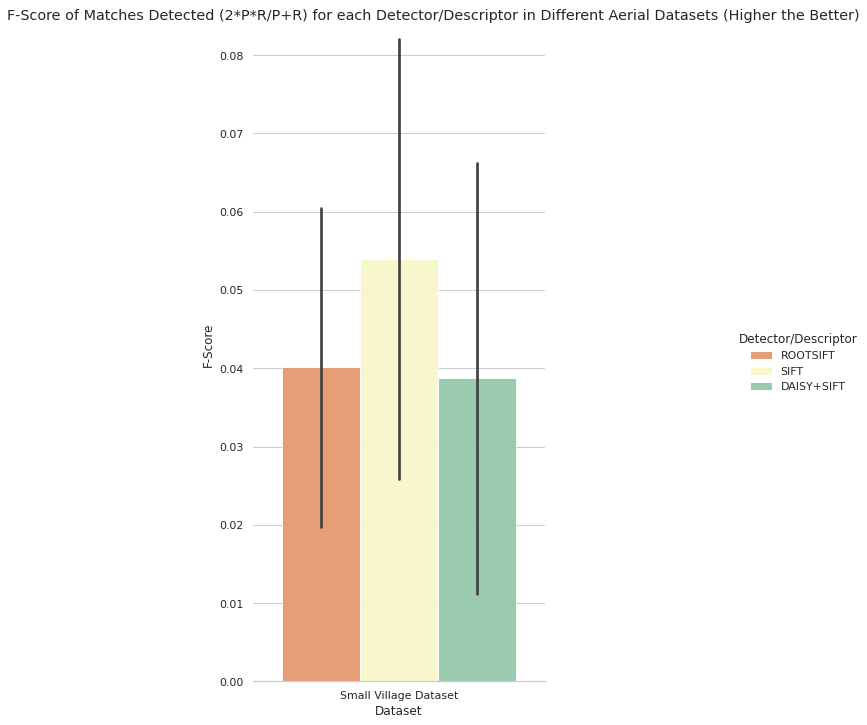

In [101]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_1.png')

In [102]:
df_match_3.to_csv('drive/MyDrive/All_metrics_3.csv')

Time for each Detector+Descriptor

In [107]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[0]] + [time_all[1]] + [time_all[2]], 'Detector/Descriptor': ['SIFT']*(1) + ['ROOTSIFT']*(1) + ['DAISY+SIFT']*(1) }
df_time_3 = pd.DataFrame(data=d)

In [108]:
print(df_time_3)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  739.386023                SIFT
1  Small Village Dataset  726.929643            ROOTSIFT
2  Small Village Dataset  748.542295          DAISY+SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

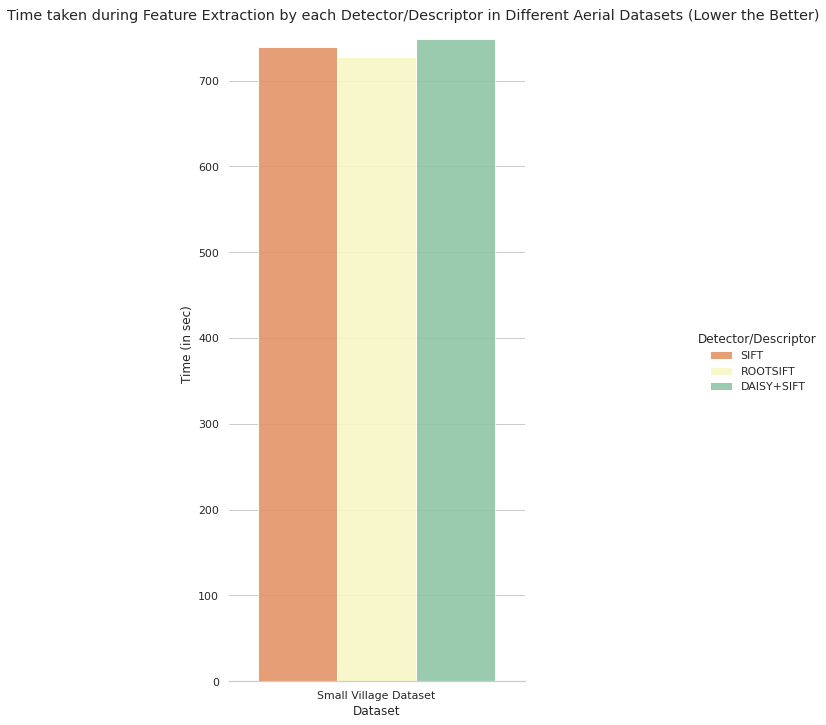

In [109]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_3, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_1.png')

In [110]:
df_time_3.to_csv('drive/MyDrive/Time_3.csv')

Stitching with CPU